## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import time
import os
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import h5py
from torchsummary import summary
from torchvision import transforms
from torch.utils import data
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from sklearn.preprocessing import normalize
from torchvision import transforms, datasets
import torch.nn as nn
import random
import torch as T
import pandas as pd
import tarfile
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tarfile
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Linear, Sequential, ReLU
import gensim.downloader as api
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
file_path = 'ag_news_csv.tar.gz'
extract_to_path = 'ag_news_csv'


with tarfile.open(file_path, 'r:gz') as file:
    file.extractall(path=extract_to_path)

print("Extraction complete!")

import pandas as pd
import tarfile
train_data_path = extract_to_path + '/ag_news_csv/train.csv'
test_data_path = extract_to_path + '/ag_news_csv/test.csv'
train_df = pd.read_csv(train_data_path, header=None, names=['Label', 'Title', 'Content'])
test_df = pd.read_csv(test_data_path, header=None, names=['Label', 'Title', 'Content'])


train_df['Text'] = train_df['Title'] + " " + train_df['Content']
test_df['Text'] = test_df['Title'] + " " + test_df['Content']

# Statistics for training and testing datasets
stats = {
    "train": {
        "num_samples": len(train_df),
        "num_unique_labels": train_df['Label'].nunique(),
        "average_text_length": train_df['Text'].apply(len).mean(),
        "min_text_length": train_df['Text'].apply(len).min(),
        "max_text_length": train_df['Text'].apply(len).max()
    },
    "test": {
        "num_samples": len(test_df),
        "num_unique_labels": test_df['Label'].nunique(),
        "average_text_length": test_df['Text'].apply(len).mean(),
        "min_text_length": test_df['Text'].apply(len).min(),
        "max_text_length": test_df['Text'].apply(len).max()
    }
}

print(stats)




Extraction complete!
{'train': {'num_samples': 120000, 'num_unique_labels': 4, 'average_text_length': 236.477525, 'min_text_length': 100, 'max_text_length': 1012}, 'test': {'num_samples': 7600, 'num_unique_labels': 4, 'average_text_length': 235.2992105263158, 'min_text_length': 100, 'max_text_length': 892}}


<ipython-input-5-99f34171c47e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=train_df, palette='viridis')
<ipython-input-5-99f34171c47e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=test_df, palette='viridis')


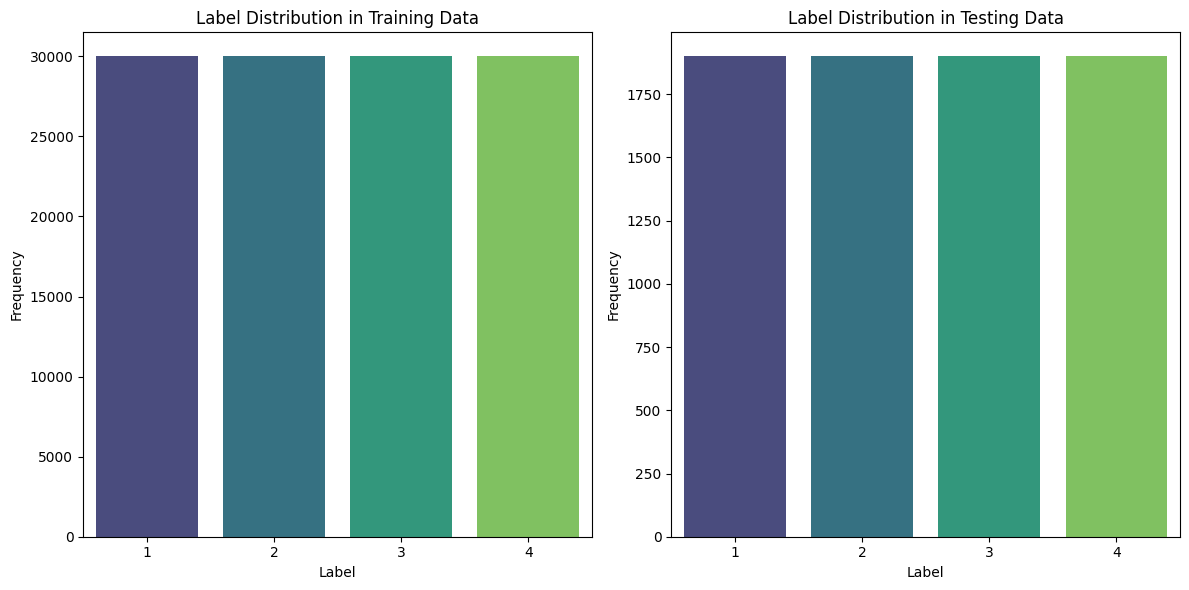

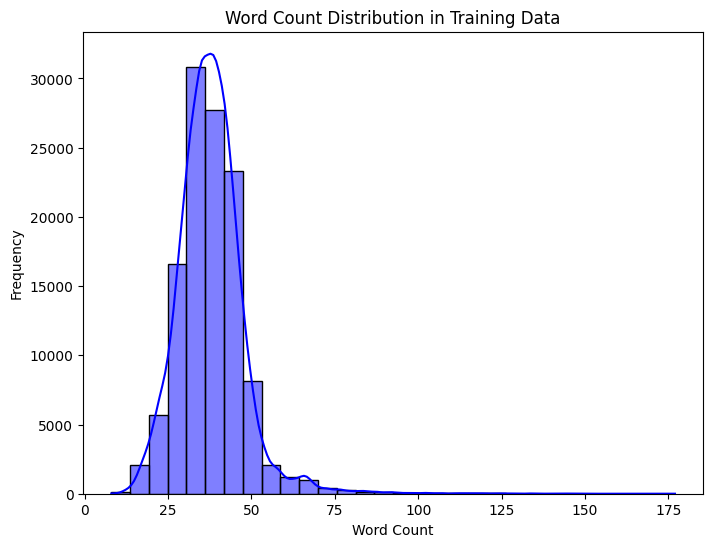

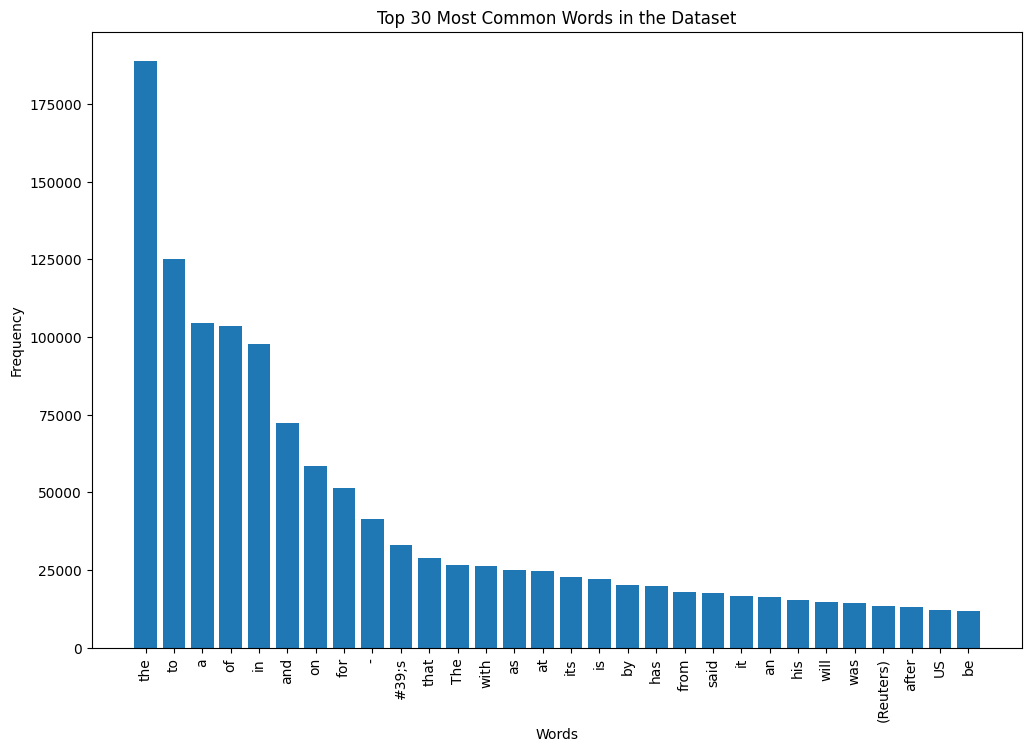

In [5]:
#Visualizations

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Label', data=train_df, palette='viridis')
plt.title('Label Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.countplot(x='Label', data=test_df, palette='viridis')
plt.title('Label Distribution in Testing Data')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

train_df['Word_Count'] = train_df['Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(train_df['Word_Count'], bins=30, kde=True, color='blue')
plt.title('Word Count Distribution in Training Data')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

from collections import Counter

all_text = pd.concat([train_df['Text'], test_df['Text']])
words = all_text.str.split().explode()
word_freq = Counter(words)

most_common_words = word_freq.most_common(30)

plt.figure(figsize=(12, 8))
words, frequencies = zip(*most_common_words)
plt.bar(words, frequencies)
plt.xticks(rotation=90)
plt.title('Top 30 Most Common Words in the Dataset')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return filtered_tokens

train_df['Tokens'] = train_df['Text'].apply(preprocess_text)
test_df['Tokens'] = test_df['Text'].apply(preprocess_text)


#### Word2Vec

In [ ]:

word2vec_model = api.load("word2vec-google-news-300")

def tokens_to_vectors(tokens):
    vectors = [word2vec_model[token] for token in tokens if token in word2vec_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

train_df['Vectors'] = train_df['Tokens'].apply(tokens_to_vectors)
test_df['Vectors'] = test_df['Tokens'].apply(tokens_to_vectors)


In [ ]:
train_df['Label'] = train_df['Label'] - 1
test_df['Label'] = test_df['Label'] - 1

In [ ]:
combined_df = pd.concat([train_df, test_df])
train_val, test_df = train_test_split(combined_df, test_size=0.15)
train_df, val_df = train_test_split(train_val, test_size=0.15 / 0.85)



In [ ]:

class TextDataset(Dataset):
    def __init__(self, vectors, labels):
        self.vectors = [torch.tensor(v, dtype=torch.float32) for v in vectors]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.vectors)

    def __getitem__(self, idx):
        return self.vectors[idx], self.labels[idx]

train_dataset = TextDataset(train_df['Vectors'].tolist(), train_df['Label'].tolist())
val_dataset = TextDataset(val_df['Vectors'].tolist(), val_df['Label'].tolist())
test_dataset = TextDataset(test_df['Vectors'].tolist(), test_df['Label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=512, nhead=8, num_layers=3, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_model * 4, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc_out = Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x.unsqueeze(1))
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.fc_out(x)

model = TransformerClassifier(word2vec_model.vector_size, 4)



/Users/charankumarnara/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
def train(model, train_loader, criterion, optimizer, device, train_accuracies, val_accuracies, train_losses, val_losses):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    total_val = 0
    correct_val = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_loss += loss.item()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy =  100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)


    # Validation
    val_loss = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

    average_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    val_losses.append(average_val_loss)


    return average_loss, average_val_loss, train_accuracies, val_accuracies, train_losses, val_losses

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    average_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / len(test_loader)
    return average_loss, accuracy


In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = TransformerClassifier(word2vec_model.vector_size, 4).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)


In [ ]:
print(model)

TransformerClassifier(
  (embedding): Linear(in_features=300, out_features=512, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=512, out_features=4, bias=True)
)


In [ ]:
num_epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    train_loss, val_loss, train_accuracies, val_accuracies, train_losses, val_losses = train(model, train_loader, criterion, optimizer, device, train_accuracies, val_accuracies, train_losses, val_losses)
    # test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch 1/15 - Train Loss: 1.3844, Val Loss: 1.3642
Epoch 2/15 - Train Loss: 1.3392, Val Loss: 1.3160
Epoch 3/15 - Train Loss: 1.2681, Val Loss: 1.2181
Epoch 4/15 - Train Loss: 1.1430, Val Loss: 1.0708
Epoch 5/15 - Train Loss: 0.9860, Val Loss: 0.9081
Epoch 6/15 - Train Loss: 0.8430, Val Loss: 0.8031
Epoch 7/15 - Train Loss: 0.7423, Val Loss: 0.7089
Epoch 8/15 - Train Loss: 0.6673, Val Loss: 0.6436
Epoch 9/15 - Train Loss: 0.6185, Val Loss: 0.6336
Epoch 10/15 - Train Loss: 0.5802, Val Loss: 0.5978
Epoch 11/15 - Train Loss: 0.5491, Val Loss: 0.5534
Epoch 12/15 - Train Loss: 0.5266, Val Loss: 0.5186
Epoch 13/15 - Train Loss: 0.5081, Val Loss: 0.5077
Epoch 14/15 - Train Loss: 0.4910, Val Loss: 0.4889
Epoch 15/15 - Train Loss: 0.4796, Val Loss: 0.4715


In [ ]:
np.array(train_accuracies)

array([28.5031348 , 35.96059113, 44.5320197 , 53.43036274, 60.75459024,
       67.05776982, 71.40058218, 74.70891178, 76.89991043, 78.50201523,
       79.94178236, 81.00201523, 81.8450515 , 82.56829378, 83.07545902])

In [ ]:
np.array(val_accuracies)

array([31.20167189, 39.22675026, 48.62591432, 57.11598746, 64.19017764,
       67.99895507, 72.34064786, 76.12330199, 76.57784744, 77.30407524,
       79.34169279, 81.01880878, 81.67189133, 82.48171369, 83.38035528])

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = total_correct / total
    return total_loss / len(data_loader), accuracy, all_labels, all_preds


In [ ]:
loss, accuracy, labels, preds = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


Test Loss: 0.4234, Test Accuracy: 0.8602


In [ ]:
precision = precision_score(preds, labels, average='macro')
recall = recall_score(preds, labels, average='macro')
f1 = f1_score(preds, labels, average='macro')
conf_matrix = confusion_matrix(preds, labels)
accuracy = accuracy_score(preds, labels)

print('Basic model results for Transformer Model')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Basic model results for Transformer Model
Accuracy:  86.02403343782655
Confusion Matrix:  [[4139  140  249  220]
 [ 182 4592   51   79]
 [ 317   92 3989  630]
 [ 156   40  519 3745]]
Precision:  85.95874091529045
Recall:  86.02893081149232
F1 Score:  85.97152909752802


In [ ]:
def print_confusion_matrix(true_test, test_predicted):
    cm = confusion_matrix(true_test, test_predicted)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def print_accuracy_plot(train_accuracies, val_accuracies, num_epochs=3):
    plt.figure(figsize=(8,6))
    epochs_range = range(1, num_epochs + 1)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('No of Epochs')
    plt.ylabel('Accuracies')
    plt.title('Accuracies for Train, Test and Validation')
    plt.legend()
    plt.show()

def print_losses_plot(train_losses, val_losses, num_epochs=3):
    plt.figure(figsize=(8,6))
    epochs_range = range(1, num_epochs + 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('No of Epochs')
    plt.ylabel('Losses')
    plt.title('Plot: Train, Test and Validation Losses')
    plt.legend()
    plt.show()

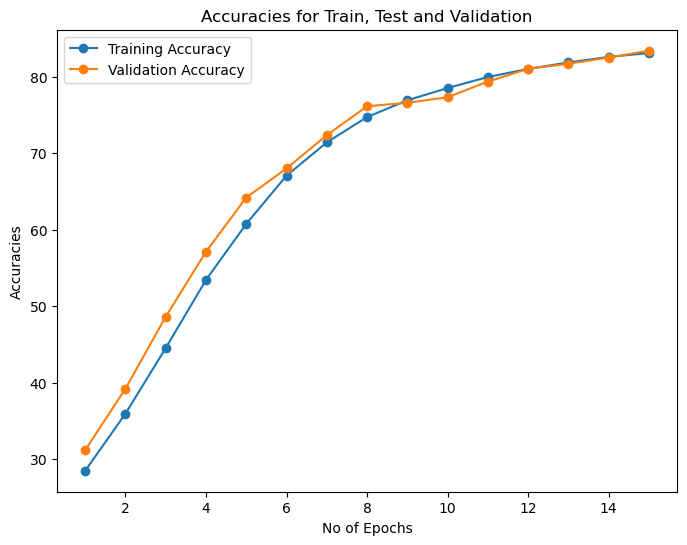

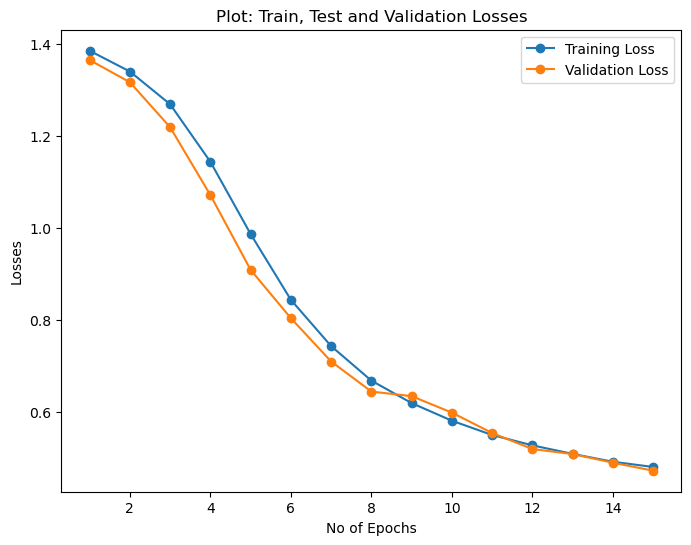

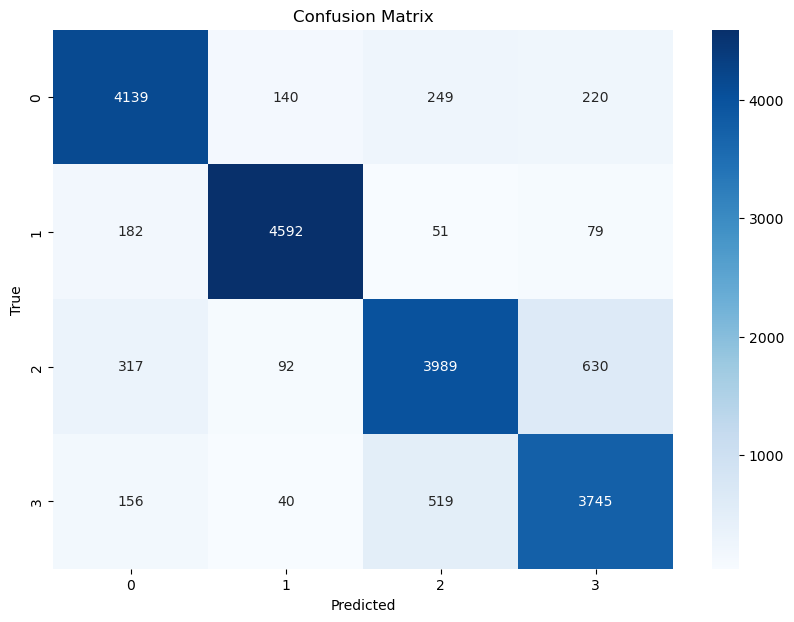

In [ ]:
print_accuracy_plot(train_accuracies, val_accuracies, 15)
print_losses_plot(train_losses, val_losses, 15)
print_confusion_matrix(preds, labels)




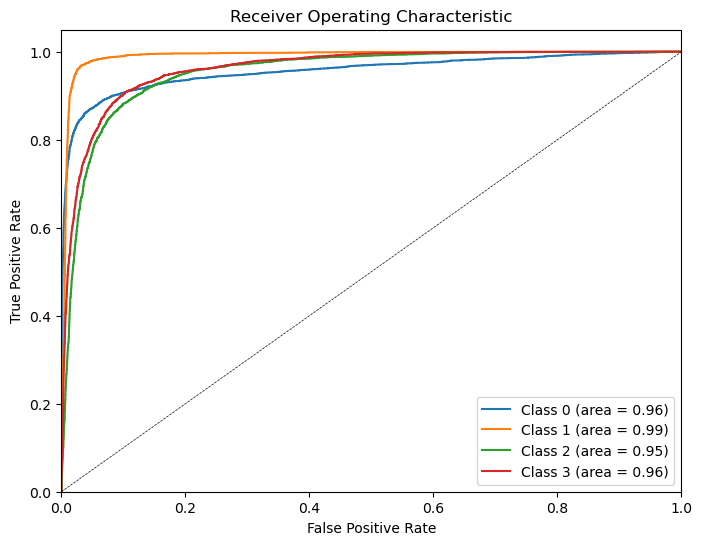

In [ ]:


def evaluate_roc(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(data_loader), all_labels, all_probs


loss, labels, probs = evaluate_roc(model, test_loader, criterion)

# Binarize labels
binary_labels = label_binarize(labels, classes=[0, 1, 2, 3])
n_classes = binary_labels.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], [p[i] for p in probs])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## L2 Regularization

In [ ]:
regularization_model = TransformerClassifier(word2vec_model.vector_size, 4).to(device)
regularization_model.to(device)

optimizer_l2 = torch.optim.SGD(regularization_model.parameters(), lr=0.0005, weight_decay=0.000001)
num_epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    train_loss, val_loss, train_accuracies, val_accuracies, train_losses, val_losses = train(regularization_model, train_loader, criterion, optimizer_l2, device, train_accuracies, val_accuracies, train_losses, val_losses)
    # test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


/Users/charankumarnara/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/15 - Train Loss: 1.3891, Val Loss: 1.3655
Epoch 2/15 - Train Loss: 1.3457, Val Loss: 1.3157
Epoch 3/15 - Train Loss: 1.2788, Val Loss: 1.2491
Epoch 4/15 - Train Loss: 1.1626, Val Loss: 1.0920
Epoch 5/15 - Train Loss: 1.0047, Val Loss: 0.9927
Epoch 6/15 - Train Loss: 0.8569, Val Loss: 0.8661
Epoch 7/15 - Train Loss: 0.7454, Val Loss: 0.7250
Epoch 8/15 - Train Loss: 0.6774, Val Loss: 0.6694
Epoch 9/15 - Train Loss: 0.6252, Val Loss: 0.5999
Epoch 10/15 - Train Loss: 0.5869, Val Loss: 0.5984
Epoch 11/15 - Train Loss: 0.5544, Val Loss: 0.5425
Epoch 12/15 - Train Loss: 0.5328, Val Loss: 0.5346
Epoch 13/15 - Train Loss: 0.5148, Val Loss: 0.5408
Epoch 14/15 - Train Loss: 0.4978, Val Loss: 0.5067
Epoch 15/15 - Train Loss: 0.4839, Val Loss: 0.4850


In [ ]:
loss, accuracy, labels, preds = evaluate(regularization_model, test_loader, criterion, device)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')
precision = precision_score(preds, labels, average='macro')
recall = recall_score(preds, labels, average='macro')
f1 = f1_score(preds, labels, average='macro')
conf_matrix = confusion_matrix(preds, labels)
accuracy = accuracy_score(preds, labels)

print('L2 Regularization model results for Transformer Model')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Test Loss: 0.4323, Test Accuracy: 0.8548
L2 Regularization model results for Transformer Model
Accuracy:  85.48066875653083
Confusion Matrix:  [[4200  155  325  288]
 [ 175 4595   53   92]
 [ 301   87 3987  715]
 [ 118   27  443 3579]]
Precision:  85.3939764966812
Recall:  85.56239225593512
F1 Score:  85.38756294514677


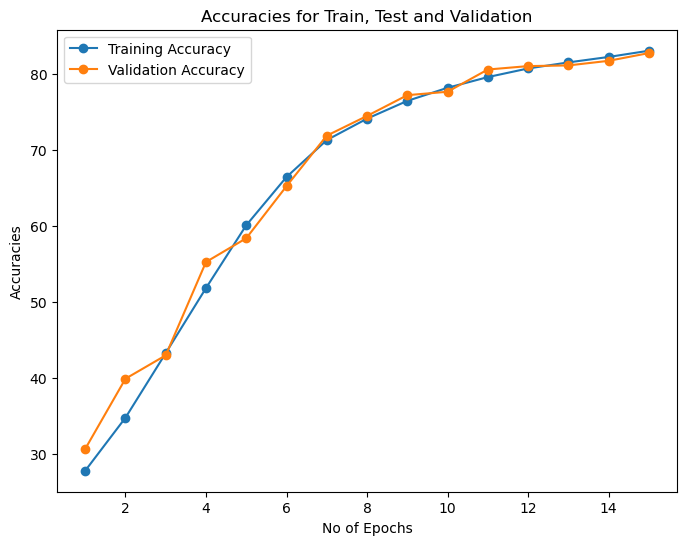

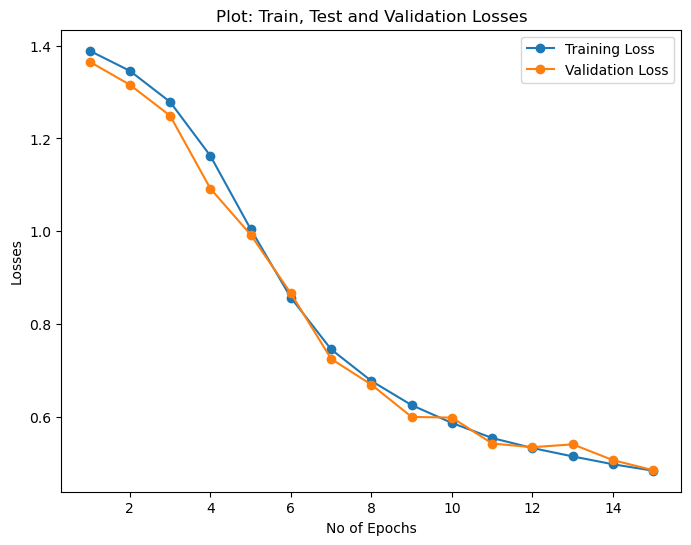

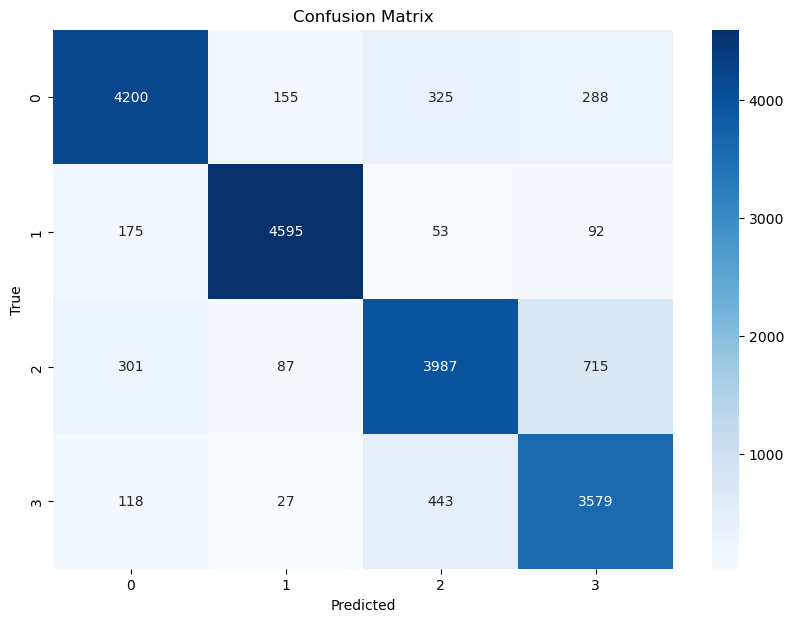

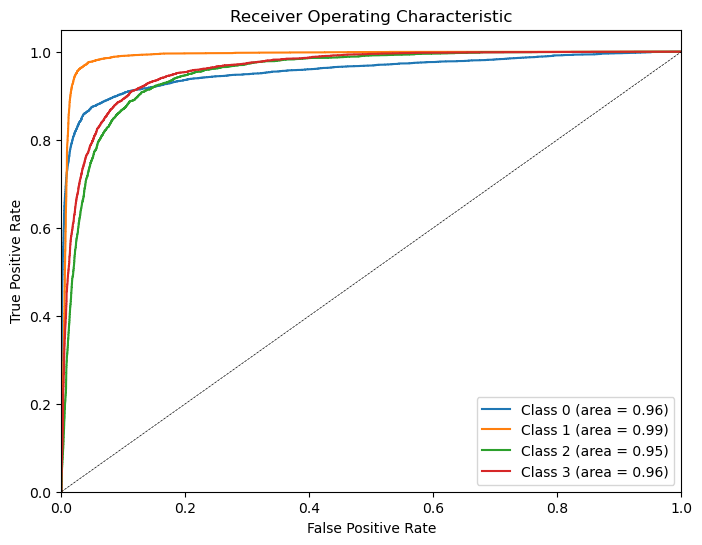

In [ ]:
print_accuracy_plot(train_accuracies, val_accuracies, 15)
print_losses_plot(train_losses, val_losses, 15)
print_confusion_matrix(preds, labels)


def evaluate_roc(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(data_loader), all_labels, all_probs


loss, labels, probs = evaluate_roc(regularization_model, test_loader, criterion)

# Binarize labels
binary_labels = label_binarize(labels, classes=[0, 1, 2, 3])
n_classes = binary_labels.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], [p[i] for p in probs])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Dropout

In [ ]:
dropout_model = TransformerClassifier(word2vec_model.vector_size, 4, dropout=0.5).to(device)
dropout_model.to(device)

optimizer_drop = torch.optim.SGD(dropout_model.parameters(), lr=0.0005)

num_epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    train_loss, val_loss, train_accuracies, val_accuracies, train_losses, val_losses = train(dropout_model, train_loader, criterion, optimizer_drop, device, train_accuracies, val_accuracies, train_losses, val_losses)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

/Users/charankumarnara/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/15 - Train Loss: 1.4361, Val Loss: 1.4154
Epoch 2/15 - Train Loss: 1.4069, Val Loss: 1.4017
Epoch 3/15 - Train Loss: 1.3941, Val Loss: 1.3912
Epoch 4/15 - Train Loss: 1.3853, Val Loss: 1.3837
Epoch 5/15 - Train Loss: 1.3810, Val Loss: 1.3776
Epoch 6/15 - Train Loss: 1.3756, Val Loss: 1.3718
Epoch 7/15 - Train Loss: 1.3715, Val Loss: 1.3681
Epoch 8/15 - Train Loss: 1.3662, Val Loss: 1.3626
Epoch 9/15 - Train Loss: 1.3603, Val Loss: 1.3587
Epoch 10/15 - Train Loss: 1.3562, Val Loss: 1.3529
Epoch 11/15 - Train Loss: 1.3494, Val Loss: 1.3482
Epoch 12/15 - Train Loss: 1.3413, Val Loss: 1.3376
Epoch 13/15 - Train Loss: 1.3344, Val Loss: 1.3319
Epoch 14/15 - Train Loss: 1.3230, Val Loss: 1.3183
Epoch 15/15 - Train Loss: 1.3109, Val Loss: 1.3054


In [ ]:
loss, accuracy, labels, preds = evaluate(dropout_model, test_loader, criterion, device)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 1.1231, Test Accuracy: 0.7132


In [ ]:
loss, accuracy, labels, preds = evaluate(regularization_model, test_loader, criterion, device)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')
precision = precision_score(preds, labels, average='macro')
recall = recall_score(preds, labels, average='macro')
f1 = f1_score(preds, labels, average='macro')
conf_matrix = confusion_matrix(preds, labels)
accuracy = accuracy_score(preds, labels)

print('dropout model results for Transformer Model')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Test Loss: 0.4323, Test Accuracy: 0.8548
dropout model results for Transformer Model
Accuracy:  85.48066875653083
Confusion Matrix:  [[4200  155  325  288]
 [ 175 4595   53   92]
 [ 301   87 3987  715]
 [ 118   27  443 3579]]
Precision:  85.3939764966812
Recall:  85.56239225593512
F1 Score:  85.38756294514677


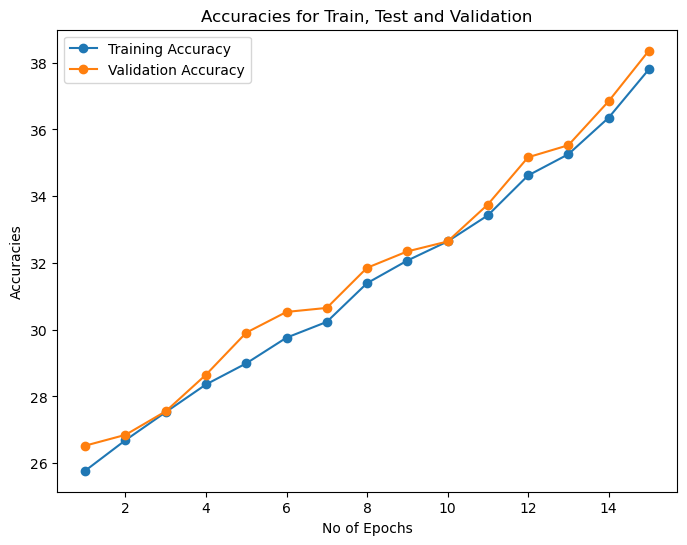

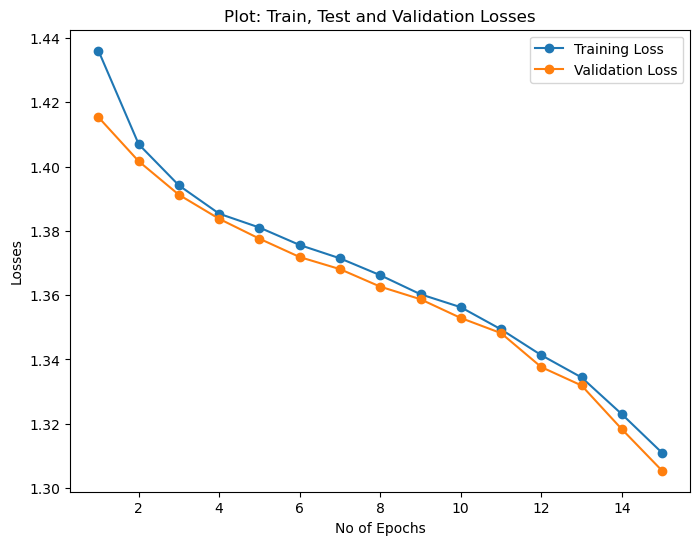

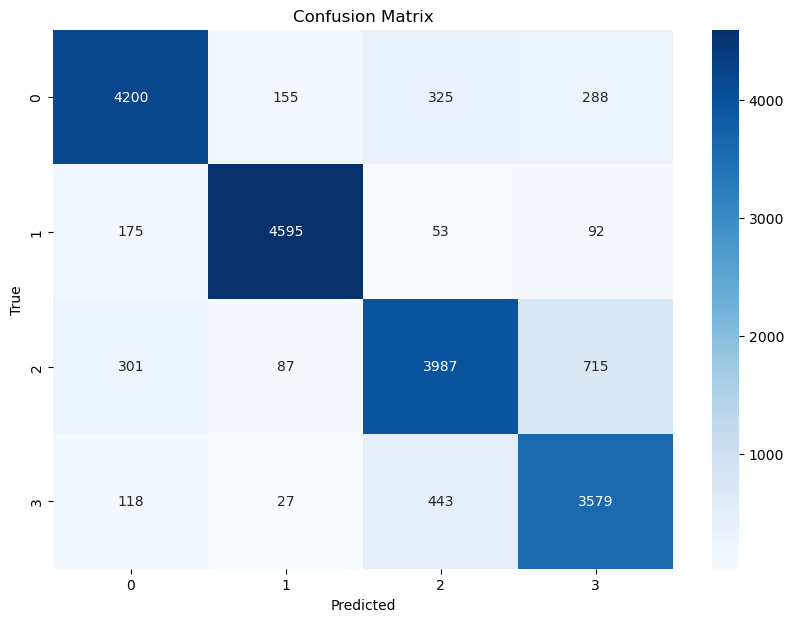

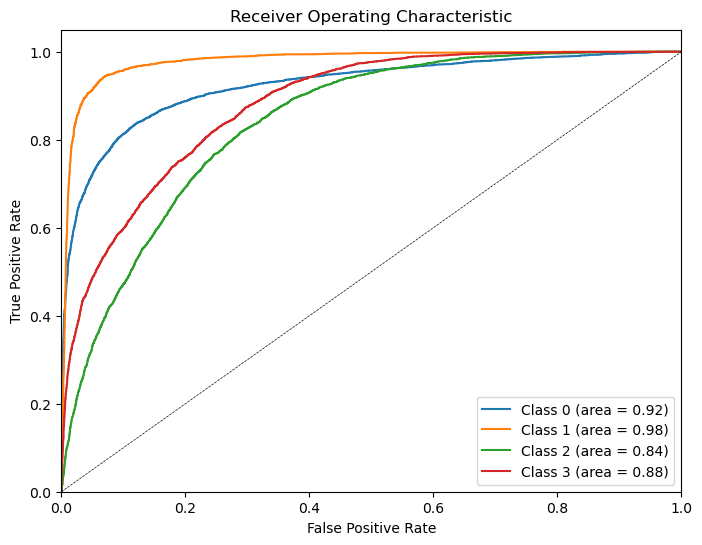

In [ ]:
print_accuracy_plot(train_accuracies, val_accuracies, 15)
print_losses_plot(train_losses, val_losses, 15)
print_confusion_matrix(preds, labels)


def evaluate_roc(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(data_loader), all_labels, all_probs


loss, labels, probs = evaluate_roc(dropout_model, test_loader, criterion)

# Binarize labels
binary_labels = label_binarize(labels, classes=[0, 1, 2, 3])
n_classes = binary_labels.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], [p[i] for p in probs])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Early stopping

In [ ]:
import torch

def earlystop_train(model, train_loader, criterion, optimizer, device, train_accuracies, val_accuracies, train_losses, val_losses, best_val_accuracy):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    total_val = 0
    correct_val = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_loss += loss.item()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy =  100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)


    # Validation
    val_loss = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_early_model_transformer.pth')


    return average_loss, average_val_loss, train_accuracies, val_accuracies, train_losses, val_losses, best_val_accuracy

In [ ]:
early_model = TransformerClassifier(word2vec_model.vector_size, 4).to(device)
early_model.to(device)
optimizer_early = torch.optim.SGD(early_model.parameters(), lr=0.0005)

num_epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0
for epoch in range(num_epochs):
    train_loss, val_loss, train_accuracies, val_accuracies, train_losses, val_losses, best_val_accuracy = earlystop_train(early_model, train_loader, criterion, optimizer_early, device, train_accuracies, val_accuracies, train_losses, val_losses, best_val_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')



best_early_model = TransformerClassifier(word2vec_model.vector_size , 4).to(device)
best_early_model.load_state_dict(torch.load('best_early_model_transformer.pth'))
best_early_model.to(device)



loss, accuracy, labels, preds = evaluate(best_early_model, test_loader, criterion, device)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')



/Users/charankumarnara/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/15 - Train Loss: 1.3860, Val Loss: 1.3644
Epoch 2/15 - Train Loss: 1.3391, Val Loss: 1.3110
Epoch 3/15 - Train Loss: 1.2634, Val Loss: 1.2070
Epoch 4/15 - Train Loss: 1.1351, Val Loss: 1.0531
Epoch 5/15 - Train Loss: 0.9781, Val Loss: 0.9258
Epoch 6/15 - Train Loss: 0.8368, Val Loss: 0.7953
Epoch 7/15 - Train Loss: 0.7393, Val Loss: 0.7070
Epoch 8/15 - Train Loss: 0.6720, Val Loss: 0.6621
Epoch 9/15 - Train Loss: 0.6227, Val Loss: 0.6123
Epoch 10/15 - Train Loss: 0.5845, Val Loss: 0.6450
Epoch 11/15 - Train Loss: 0.5510, Val Loss: 0.5582
Epoch 12/15 - Train Loss: 0.5303, Val Loss: 0.5291
Epoch 13/15 - Train Loss: 0.5141, Val Loss: 0.5189
Epoch 14/15 - Train Loss: 0.4990, Val Loss: 0.4931
Epoch 15/15 - Train Loss: 0.4853, Val Loss: 0.4801
Test Loss: 0.4298, Test Accuracy: 0.8592


In [ ]:
loss, accuracy, labels, preds = evaluate(regularization_model, test_loader, criterion, device)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')
precision = precision_score(preds, labels, average='macro')
recall = recall_score(preds, labels, average='macro')
f1 = f1_score(preds, labels, average='macro')
conf_matrix = confusion_matrix(preds, labels)
accuracy = accuracy_score(preds, labels)

print('Early stopping model results for Transformer Model')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Test Loss: 0.4323, Test Accuracy: 0.8548
Early stopping model results for Transformer Model
Accuracy:  85.48066875653083
Confusion Matrix:  [[4200  155  325  288]
 [ 175 4595   53   92]
 [ 301   87 3987  715]
 [ 118   27  443 3579]]
Precision:  85.3939764966812
Recall:  85.56239225593512
F1 Score:  85.38756294514677


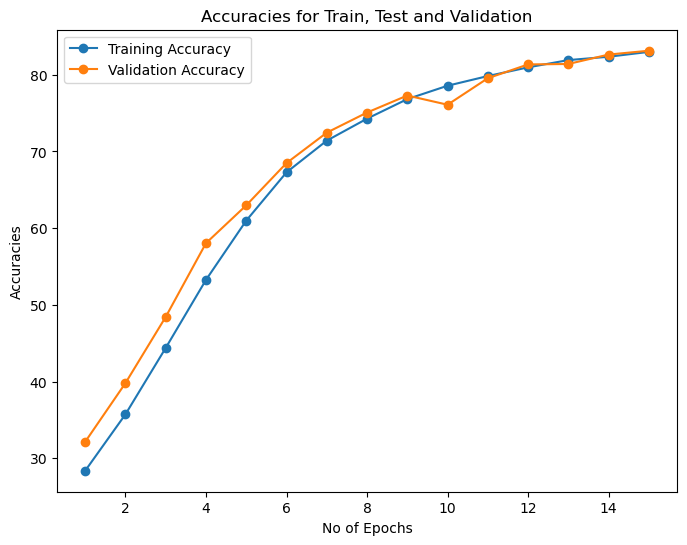

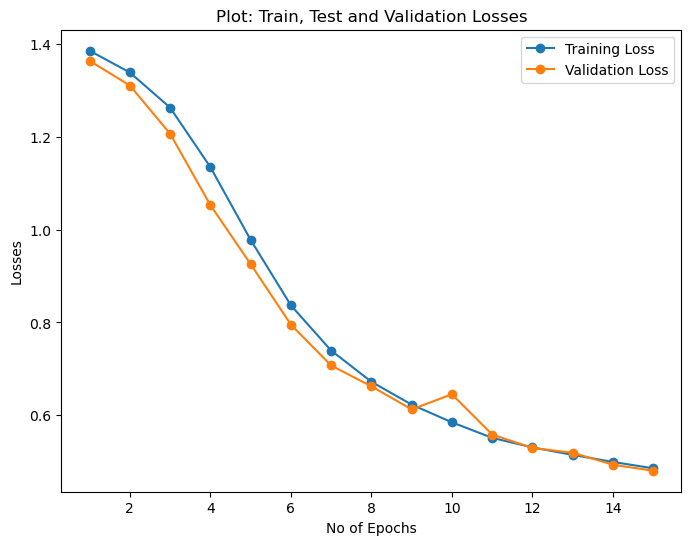

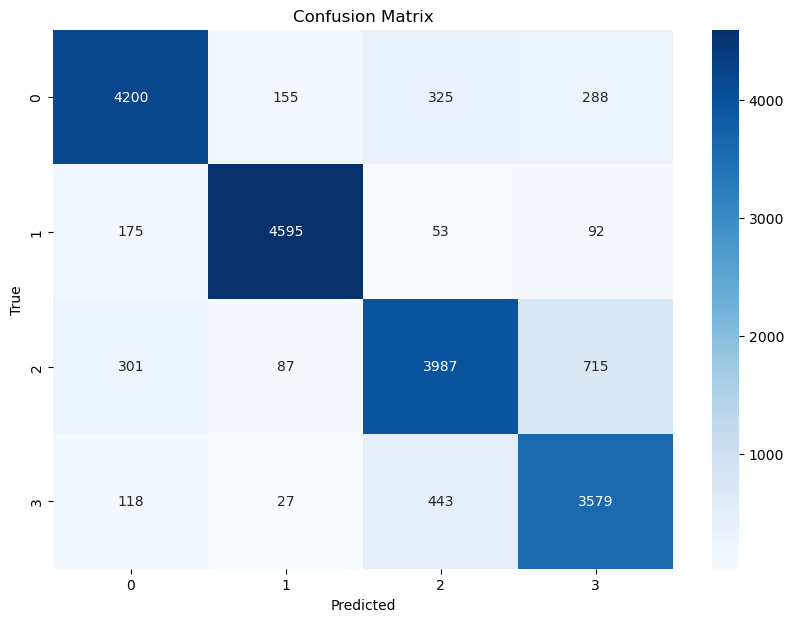

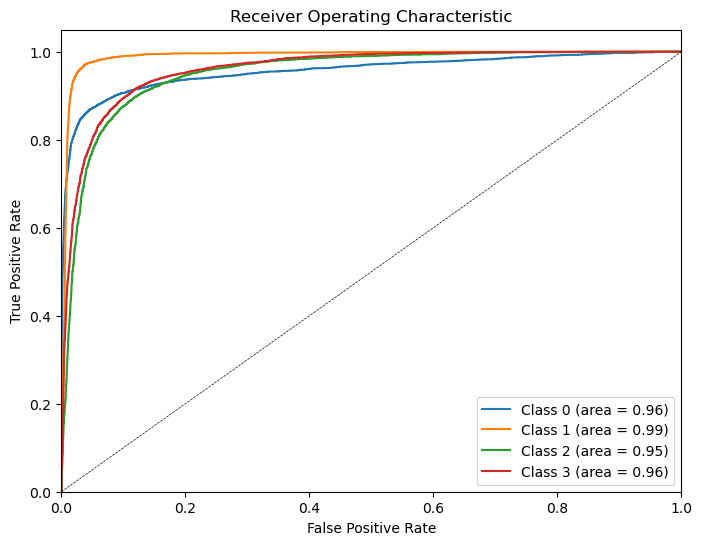

In [ ]:
print_accuracy_plot(train_accuracies, val_accuracies, 15)
print_losses_plot(train_losses, val_losses, 15)
print_confusion_matrix(preds, labels)


def evaluate_roc(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(data_loader), all_labels, all_probs


loss, labels, probs = evaluate_roc(best_early_model, test_loader, criterion)

# Binarize labels
binary_labels = label_binarize(labels, classes=[0, 1, 2, 3])
n_classes = binary_labels.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], [p[i] for p in probs])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Base model gave the best results

# Saving model

torch.save(model.state_dict(), 'cnara_kushakum_assignment2_part4.h5')